#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [186]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [375]:
#here we specify a 'true' latent function lambda
#scale = lambda x: 0.7*np.sin(np.pi*3*x)#*np.cos(2*np.pi*3*x+0.3)*5.+6. #np.sin(2*np.pi*3*x+.6)
def scale1(x):
    if (x>0.48) & (x<0.5):
        return -.7
    else:
        return np.sin(np.pi*3*x)
    
scale = np.vectorize(scale1)

In [363]:
np.around(0.0543653,2)

0.05

(50, 2)


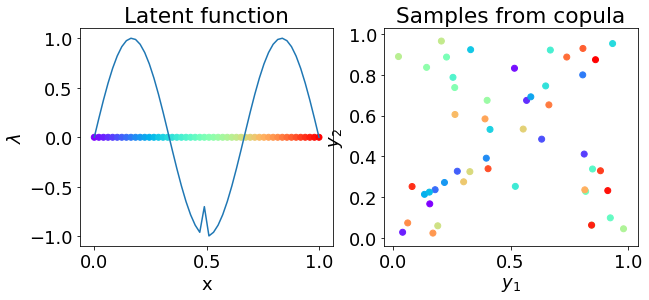

In [365]:
# here we generate some synthetic samples
import matplotlib.cm as cm
from gpytorch.distributions import base_distributions

NSamp = int(50)

X = np.linspace(0.,1.,NSamp)

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

scales = [scale(x) for x in X]

lambdaf.plot(X,scales)#+0.5*base_distributions.Normal(0,1).sample(torch.Size([NSamp])).numpy())
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

model = GaussianCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [366]:
Y[Y!=Y]

array([], dtype=float32)

In [367]:
Y[Y==1]

array([], dtype=float32)

In [368]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [377]:
# define the model (optionally on GPU)
grid_size = NSamp
model = GPInferenceModel(train_x, GaussianCopula_Likelihood()).cuda(device=0)
#likelihood = GaussianCopula_Likelihood()#.cuda(device=0)
#model = KISS_GPInferenceModel(GaussianCopula_Likelihood(), prior_rbf_length=0.3, grid_size=grid_size).cuda(device=0)

In [383]:
# train the model

base_lr = 1e-2
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .01},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .01}, #, 'lr': 0.001
    {'params': model.likelihood.noise_covar.raw_noise, 'lr': .01} #should change slower than variance
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means, noises = [], [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans=0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        #print(output.mean)
        assert torch.all(output.mean==output.mean)
        loss = -mll(output, train_y) + torch.exp(1-model.covar_module.base_kernel.lengthscale*grid_size).sum()
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        noises.append(model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}, len: {:.3}, outscale: {:.3} noise: {:.3}, dLoss: {:.3}, \
            mean f: {:.3}, dmean: {:.3}, NaNs fixed: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), 
                model.covar_module.raw_outputscale.item(),
                model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item(),
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1])),
                nans
            ))
            nans=0
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p < 0.001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
        for par in model.parameters():
            grad = par.grad.data
            nans+=torch.nonzero(grad!=grad).shape[0]
            if torch.any(grad.abs()==float('inf')):
                print("Grad inf... fixing...")
                grad = torch.clamp(grad,-1.,1.)
            grad[grad!=grad] = 0.0
            par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.0289, len: 0.157, outscale: 1.63 noise: 0.0287, dLoss: 0.0,             mean f: 0.36, dmean: 0.00248, NaNs fixed: 0
Iter 200/2000 - Loss: -0.0419, len: 0.158, outscale: 1.65 noise: 0.0194, dLoss: 0.00801,             mean f: 0.361, dmean: 0.00252, NaNs fixed: 0
Iter 300/2000 - Loss: -0.0332, len: 0.159, outscale: 1.68 noise: 0.0149, dLoss: 0.000979,             mean f: 0.361, dmean: 0.0024, NaNs fixed: 0
Converged!
CPU times: user 6.96 s, sys: 732 ms, total: 7.69 s
Wall time: 7.68 s


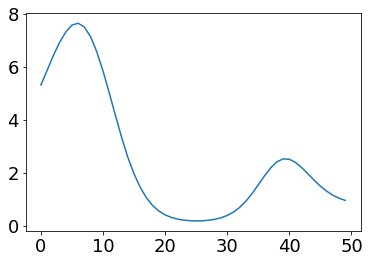

In [384]:
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

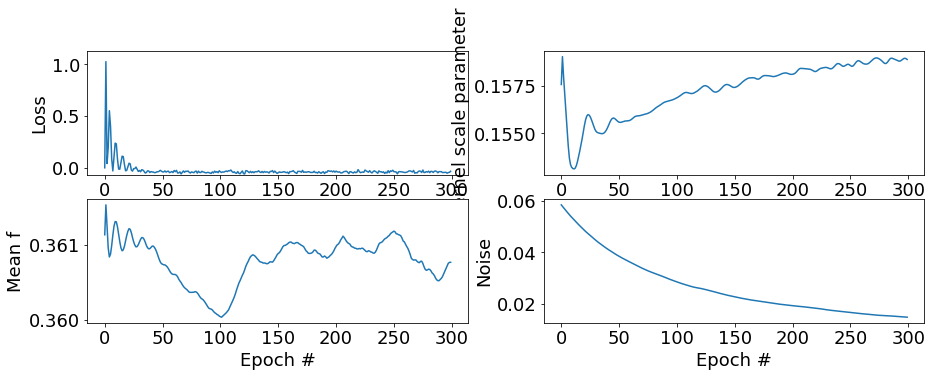

In [386]:
# prot loss function and kernel length
fig, ((lossp, kern), (mean, noise)) = plt.subplots(2,2,figsize=(15,5))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
lossp.set_ylim(np.min(losses)*1.1,np.max(losses)*1.1)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
noise.plot(noises)
noise.set_xlabel("Epoch #")
noise.set_ylabel("Noise")
fig.show()

In [387]:
# define test set (optionally on GPU)
denser = 1 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

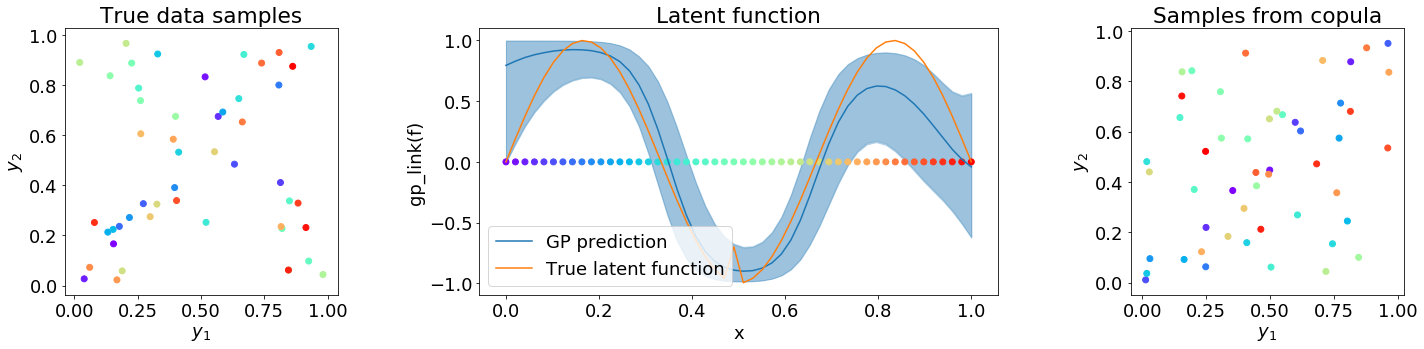

In [388]:
# visualize the result
fig, (true, nul0, nul, sim) = plt.subplots(1,4,figsize=(24, 4.9))

nul0.set_axis_off()
nul.set_axis_off()

plt.rcParams.update({'font.size': 18})

func = fig.add_axes([.365,0.125,.3,.755])

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
samples = output.rsample(torch.Size([2048]))
F_mean = gplink(samples).mean(0).detach().cpu().numpy()
#F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
noise = model.likelihood.noise_covar.raw_noise_constraint.transform(model.likelihood.noise_covar.raw_noise).item()
func.fill_between(testX, gplink(lower-noise).detach().cpu().numpy(),
                gplink(upper+noise).detach().cpu().numpy(), color=line.get_color(), alpha=0.25)
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.25)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
#print(Y_sim.shape)
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[:,:,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula')
true.set_title('True data samples')
# samp.legend()

plt.subplots_adjust(wspace=0.3)

plt.savefig('poster_img/gp.svg')